## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [15]:
# Import warnings
import warnings


In [16]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

# Try loading one file

df = pd.read_parquet(r'C:\Users\admin\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\trip_records\2023-1.parquet')
# print(df[df['fare_amount']<0])
print(df.head())

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [26]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload
# !pip install scipy

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
import os
import pandas as pd

# Change working directory
os.chdir(r'C:\Users\admin\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\trip_records')

# List all parquet files
file_list = os.listdir()

# Initialise final dataframe to collect all sampled data
final_df = pd.DataFrame()

# Loop through each monthly file
for file_name in file_list:
    try:
        file_path = os.path.join(os.getcwd(), file_name)
        df = pd.read_parquet(file_path)

        # Ensure datetime format
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

        # Extract date and hour
        df['date'] = df['tpep_pickup_datetime'].dt.date
        df['hour'] = df['tpep_pickup_datetime'].dt.hour

        # Split into negatives and positives
        negatives = df[df['fare_amount'] < 0]
        positives = df[df['fare_amount'] >= 0]

        # Sample 5% from each hour of positives
        sampled_data = []
        for date in positives['date'].unique():
            df_day = positives[positives['date'] == date]
            for hour in range(24):
                df_hour = df_day[df_day['hour'] == hour]
                if not df_hour.empty:
                    sampled_hour = df_hour.sample(frac=0.05, random_state=1)
                    sampled_data.append(sampled_hour)

        # Add all negatives (so they’re not missed in sampling)
        if not negatives.empty:
            sampled_data.append(negatives)

        # Combine for this month
        if sampled_data:
            month_sampled_df = pd.concat(sampled_data, ignore_index=True)
            final_df = pd.concat([final_df, month_sampled_df], ignore_index=True)

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

# Print a small preview of the final result
print(final_df.head())
print(f"Total sampled rows: {len(final_df)}")


Error reading file sampled_Date.csv: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:55:17   2023-01-01 01:03:27              1.0   
1         2  2023-01-01 00:29:29   2023-01-01 00:35:05              1.0   
2         2  2023-01-01 00:41:54   2023-01-01 01:38:40              1.0   
3         2  2023-01-01 00:49:37   2023-01-01 01:05:42              1.0   
4         2  2023-01-01 00:04:29   2023-01-01 00:04:33              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.14         1.0                  N           264           264   
1           0.98         1.0                  N           113            79   
2           7.56         1.0                  N            48           189   
3           3.44         1.0                  N

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [75]:
# Store the df in csv/parquet
final_df.to_parquet(r'C:\Users\admin\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\output\sampled_Data1.parquet')
final_df.to_csv(r'C:\Users\admin\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\output\sampled_Data1.csv')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [77]:
# Load the new data file
new_data_df=pd.read_parquet(r'C:\Users\admin\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\output\sampled_Data.parquet')


In [79]:
new_data_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:55:17   2023-01-01 01:03:27              1.0   
1         2  2023-01-01 00:29:29   2023-01-01 00:35:05              1.0   
2         2  2023-01-01 00:41:54   2023-01-01 01:38:40              1.0   
3         2  2023-01-01 00:49:37   2023-01-01 01:05:42              1.0   
4         2  2023-01-01 00:04:29   2023-01-01 00:04:33              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.14         1.0                  N           264           264   
1           0.98         1.0                  N           113            79   
2           7.56         1.0                  N            48           189   
3           3.44         1.0                  N           238           170   
4           0.00         5.0                  N           122           122   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             2  ...      0.5        0.00           0.0   
1             1  ...      0.5        1.00           0.0   
2             1  ...      0.5       11.82           0.0   
3             1  ...      0.5        2.34           0.0   
4             1  ...      0.5       10.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         16.40                   2.5          0.0   
1                    1.0         13.90                   2.5          0.0   
2                    1.0         70.92                   2.5          0.0   
3                    1.0         25.74                   2.5          0.0   
4                    1.0         81.50                   0.0          0.0   

         date  hour Airport_fee  
0  2023-01-01     0         NaN  
1  2023-01-01     0         NaN  
2  2023-01-01     0         NaN  
3  2023-01-01     0         NaN  
4  2023-01-01     0         NaN  

[5 rows x 22 columns]

In [83]:
new_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991327 entries, 0 to 1991326
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [85]:
# Fix the index and drop any columns that are not needed
columns_to_drop = [ 'date', 'hour', 'store_and_fwd_flag']
final_df_cleaned = new_data_df.drop(columns=columns_to_drop, errors='ignore')

final_df_cleaned.reset_index(drop=True, inplace=True)


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [87]:
# Combine the two airport fee columns
final_df_cleaned['airport_fee'] = final_df_cleaned[['airport_fee', 'Airport_fee']].sum(axis=1, skipna=True)

# Drop the redundant column
final_df_cleaned.drop(columns=['Airport_fee'], inplace=True)

# Optional: reset index after combining and dropping
final_df_cleaned.reset_index(drop=True, inplace=True)


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [89]:
# check where values of fare amount are negative

# negative_fares = final_df_cleaned[final_df_cleaned['mta_tax'] < 0]
# print(f"Total rows with negative fare: {len(negative_fares)}")
monetary_columns = ['fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount', 
                    'extra', 'improvement_surcharge', 'total_amount', 
                    'congestion_surcharge', 'airport_fee']

# Find rows with any negative values in these columns
negative_rows = final_df_cleaned[(final_df_cleaned[monetary_columns] < 0).any(axis=1)]

print(f"Total rows with any negative monetary value: {len(negative_rows)}")

Total rows with any negative monetary value: 96


Did you notice something different in the `RatecodeID` column for above records?

In [91]:
# Analyse RatecodeID for the negative fare amounts

print(negative_rows['RatecodeID'].unique())

[2. 1. 5.]


In [93]:
# Find which columns have negative values
# Check for negative values in all columns
negative_columns = final_df_cleaned.select_dtypes(include='number').lt(0).any()

# Filter to only show columns with negative values
columns_with_negatives = negative_columns[negative_columns].index.tolist()

print("Columns with negative values:")
print(columns_with_negatives)



Columns with negative values:
['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


In [95]:
# fix these negative values
# List of monetary columns typically expected to be non-negative
monetary_columns = [
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee'
]

# Replace all negative values in those columns with 0
final_df_cleaned[monetary_columns] = final_df_cleaned[monetary_columns].clip(lower=0)



### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [97]:
# Find the proportion of missing values in each column

missing_proportions = final_df_cleaned.isnull().mean().sort_values(ascending=False)
# print(missing_proportions)
print(missing_proportions[missing_proportions > 0])

congestion_surcharge    0.032394
passenger_count         0.032394
RatecodeID              0.032394
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [99]:
# Display the rows with null values
missing_passengers = final_df_cleaned[final_df_cleaned['passenger_count'].isnull()]
print(missing_passengers)
print(f"Total missing passenger_count rows: {len(missing_passengers)}")

# Impute NaN values in 'passenger_count'
final_df_cleaned['passenger_count'] = final_df_cleaned['passenger_count'].fillna(1)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
13              2  2023-01-01 00:52:43   2023-01-01 01:34:30              NaN   
22              2  2023-01-01 00:55:04   2023-01-01 01:08:56              NaN   
26              2  2023-01-01 00:28:53   2023-01-01 00:53:25              NaN   
43              2  2023-01-01 00:42:00   2023-01-01 00:46:00              NaN   
50              1  2023-01-01 00:57:58   2023-01-01 01:21:28              NaN   
...           ...                  ...                   ...              ...   
1991222         1  2023-09-29 17:44:56   2023-09-29 17:54:42              NaN   
1991233         2  2023-09-29 17:13:00   2023-09-29 18:07:00              NaN   
1991255         1  2023-09-29 18:24:02   2023-09-29 18:35:20              NaN   
1991273         1  2023-09-29 19:03:19   2023-09-29 19:09:38              NaN   
1991290         2  2023-09-29 21:30:49   2023-09-29 22:09:52              NaN   

         trip_distance  Rat

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [101]:
# Fix missing values in 'RatecodeID'
missing_ratecode = final_df_cleaned[final_df_cleaned['RatecodeID'].isnull()]
# print(missing_ratecode)
# mode_value = final_df_cleaned['RatecodeID'].mode()[0]
# mean_value = final_df_cleaned['RatecodeID'].mean() 
# print(mode_value)1.0
# print(mean_value) 1.6200508505132507


print(f"Missing RatecodeID values: {final_df_cleaned['RatecodeID'].isnull().sum()}")
final_df_cleaned['RatecodeID'] = final_df_cleaned['RatecodeID'].fillna(1)


Missing RatecodeID values: 64508


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [103]:
# handle null values in congestion_surcharge
missing_ratecode = final_df_cleaned[final_df_cleaned['congestion_surcharge'].isnull()]
# print(congestion_surcharge)
# mean_value = final_df_cleaned['congestion_surcharge'].mean() -2.3
mode_val= final_df_cleaned['congestion_surcharge'].mode()[0]
print(mode_val)

# print(f"Missing congestion_surcharge values: {final_df_cleaned['congestion_surcharge'].isnull().sum()}")
final_df_cleaned['congestion_surcharge'] = final_df_cleaned['congestion_surcharge'].fillna(mode_val)




2.5


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [105]:
# Handle any remaining missing values
# Numerical columns to fill with 0
num_cols_fill_zero = ['tip_amount', 'airport_fee', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge']

for col in num_cols_fill_zero:
    if col in final_df_cleaned.columns:
        final_df_cleaned[col] = final_df_cleaned[col].fillna(0)

# Categorical columns to fill with mode or default
cat_cols_fill = {
    'store_and_fwd_flag': 'N',
    'payment_type': final_df_cleaned['payment_type'].mode()[0] if 'payment_type' in final_df_cleaned.columns else None
}

for col, fill_value in cat_cols_fill.items():
    if col in final_df_cleaned.columns and fill_value is not None:
        final_df_cleaned[col] = final_df_cleaned[col].fillna(fill_value)



### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [107]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
print(final_df_cleaned.describe(include='all'))


# Passenger count — typically between 1 and 6 or so
print(final_df_cleaned['passenger_count'].value_counts().sort_index())

# # Trip distance — check for zeros or extremely large values
print(final_df_cleaned['trip_distance'].describe())
print(final_df_cleaned[final_df_cleaned['trip_distance'] <= 0])  # Zero or negative distance

# # Payment type — check for unusual codes
# print(final_df_cleaned['payment_type'].value_counts())

# # RatecodeID — check for invalid codes
print(final_df_cleaned['RatecodeID'].value_counts())

# # Fare amount — check for negative or zero fares
print(final_df_cleaned[final_df_cleaned['fare_amount'] <= 0])


           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.991327e+06                     1991327                     1991327   
mean   1.736749e+00  2023-07-02 19:56:57.019203  2023-07-02 20:14:24.808689   
min    1.000000e+00         2022-12-31 23:44:31         2022-12-31 23:48:47   
25%    1.000000e+00         2023-04-02 16:09:33         2023-04-02 16:26:56   
50%    2.000000e+00         2023-06-27 15:43:19         2023-06-27 16:02:16   
75%    2.000000e+00         2023-10-06 19:36:00  2023-10-06 19:53:57.500000   
max    6.000000e+00         2023-12-31 23:59:57         2024-01-01 20:50:55   
std    4.454430e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.991327e+06   1.991327e+06  1.991327e+06  1.991327e+06   
mean      1.358468e+00   4.127864e+00  1.620051e+00  1.652100e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.

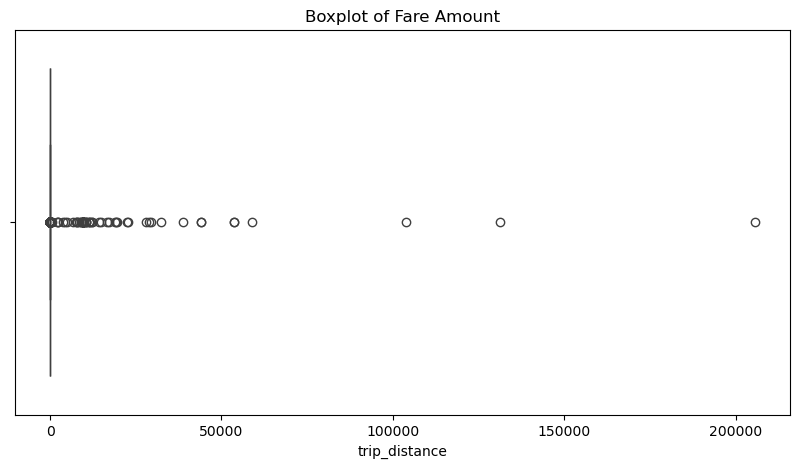

In [109]:
# Boxplot for fare_amount
plt.figure(figsize=(10, 5))
sns.boxplot(x=final_df_cleaned['trip_distance'])
plt.title('Boxplot of Fare Amount')
plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [111]:
# remove passenger_count > 6
final_df_cleaned = final_df_cleaned[final_df_cleaned['passenger_count'] <= 6]

In [113]:
# Continue with outlier handling
condition = (final_df_cleaned['trip_distance'] < 0.1) & (final_df_cleaned['fare_amount'] > 300)
print(f"Rows with trip_distance < 0.1 and fare_amount > 300: {(condition).sum()}")

final_df_cleaned = final_df_cleaned[~condition]


condition = (final_df_cleaned['trip_distance'] == 0) & (final_df_cleaned['fare_amount'] == 0) & \
            (final_df_cleaned['PULocationID'] != final_df_cleaned['DOLocationID'])

print(f"Rows with zero distance & fare but different zones: {(condition).sum()}")

final_df_cleaned = final_df_cleaned[~condition]


condition = final_df_cleaned['trip_distance'] > 250
print(f"Rows with trip_distance > 250 miles: {(condition).sum()}")

final_df_cleaned = final_df_cleaned[~condition]

condition = final_df_cleaned['payment_type'] == 0
print(f"Rows with payment_type == 0: {(condition).sum()}")

final_df_cleaned = final_df_cleaned[final_df_cleaned['payment_type'] != 0]




Rows with trip_distance < 0.1 and fare_amount > 300: 45
Rows with zero distance & fare but different zones: 81
Rows with trip_distance > 250 miles: 60
Rows with payment_type == 0: 64471


In [117]:
# Do any columns need standardising?
The fee and amount columns might require
Monetary / Fare-related columns:
    fare_amount
    extra
    mta_tax
    tip_amount
    tolls_amount
    improvement_surcharge
    total_amount
    congestion_surcharge
    airport_fee

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [119]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'date',
 'hour',
 'Airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`


In [ ]:
Categorical Variables
    These represent discrete labels or categories and are often used for grouping or classification:
    
    VendorID → Categorical (represents a taxi company/vendor)
    
    RatecodeID → Categorical (represents the rate type of the trip)
    
    PULocationID → Categorical (represents pickup location zone)
    
    DOLocationID → Categorical (represents dropoff location zone)
    
    payment_type → Categorical (represents the payment method used)

Datetime/Time Variables
    These are time-based and often transformed into numerical features like hour, day, etc.:
    
    tpep_pickup_datetime → Datetime
    
    tpep_dropoff_datetime → Datetime
    
    pickup_hour → Numerical (derived from pickup time, represents hour of day)
    
    trip_duration → Numerical (derived in minutes or seconds from pickup and dropoff time)

Numerical Variables
    These are continuous or discrete values that can be measured:
    
    passenger_count → Numerical
    
    trip_distance → Numerical

Monetary Parameters (All are Numerical)
    fare_amount → Numerical
    
    extra → Numerical
    
    mta_tax → Numerical
    
    tip_amount → Numerical
    
    tolls_amount → Numerical
    
    improvement_surcharge → Numerical
    
    total_amount → Numerical
    
    congestion_surcharge → Numerical
    
    airport_fee → Numerical

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [121]:
# Find and show the hourly trends in taxi pickups

df = final_df_cleaned.copy()

# Ensure datetime type
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract hour, day of week, and month
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.day_name()  # e.g. Monday, Tuesday
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()    # e.g. January, February

# Number of pickups by hour
hourly_counts = df.groupby('pickup_hour').size()

# Number of pickups by day of week (order Monday to Sunday)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df.groupby('pickup_dayofweek').size().reindex(days_order)

# Number of pickups by month (ordered Jan to Dec)
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                'August', 'September', 'October', 'November', 'December']
monthly_counts = df.groupby('pickup_month').size().reindex(months_order)

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# Plot pickups by hour
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='skyblue')
plt.title('Taxi Pickups by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.tight_layout()
plt.show()

In [125]:
# Find and show the daily trends in taxi pickups (days of the week)
# Plot pickups by day of week
sns.barplot(x=daily_counts.index, y=daily_counts.values, color='yellow')
plt.title('Taxi Pickups by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Pickups')
plt.tight_layout()
plt.show()

In [127]:
# Show the monthly trends in pickups
# Plot pickups by month
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='pink')
plt.title('Taxi Pickups by Month')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [129]:
# Analyse the above parameters
# Columns to check
financial_cols = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

# Loop through each column and print counts of zero or negative values
for col in financial_cols:
    zero_count = (final_df_cleaned[col] == 0).sum()
    negative_count = (final_df_cleaned[col] < 0).sum()
    total_count = len(final_df_cleaned)
    print(f"Column '{col}':")
    print(f"  Zero values count: {zero_count} ({zero_count/total_count:.4%})")
    print(f"  Negative values count: {negative_count} ({negative_count/total_count:.4%})\n")



Column 'fare_amount':
  Zero values count: 584 (0.0303%)
  Negative values count: 0 (0.0000%)

Column 'tip_amount':
  Zero values count: 430903 (22.3656%)
  Negative values count: 0 (0.0000%)

Column 'total_amount':
  Zero values count: 336 (0.0174%)
  Negative values count: 0 (0.0000%)

Column 'trip_distance':
  Zero values count: 22738 (1.1802%)
  Negative values count: 0 (0.0000%)



Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [131]:
# Create a df with non zero entries for the selected parameters.
cols_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

filtered_df = final_df_cleaned.copy()

# Filter out rows where any of these columns have zero or negative values
for col in cols_to_check:
    filtered_df = filtered_df[filtered_df[col] > 0]

filtered_df.reset_index(drop=True, inplace=True)

print(f"Original rows: {len(final_df_cleaned)}")
print(f"Filtered rows (no zeros/negatives in key columns): {len(filtered_df)}")



Original rows: 1926637
Filtered rows (no zeros/negatives in key columns): 1487237


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

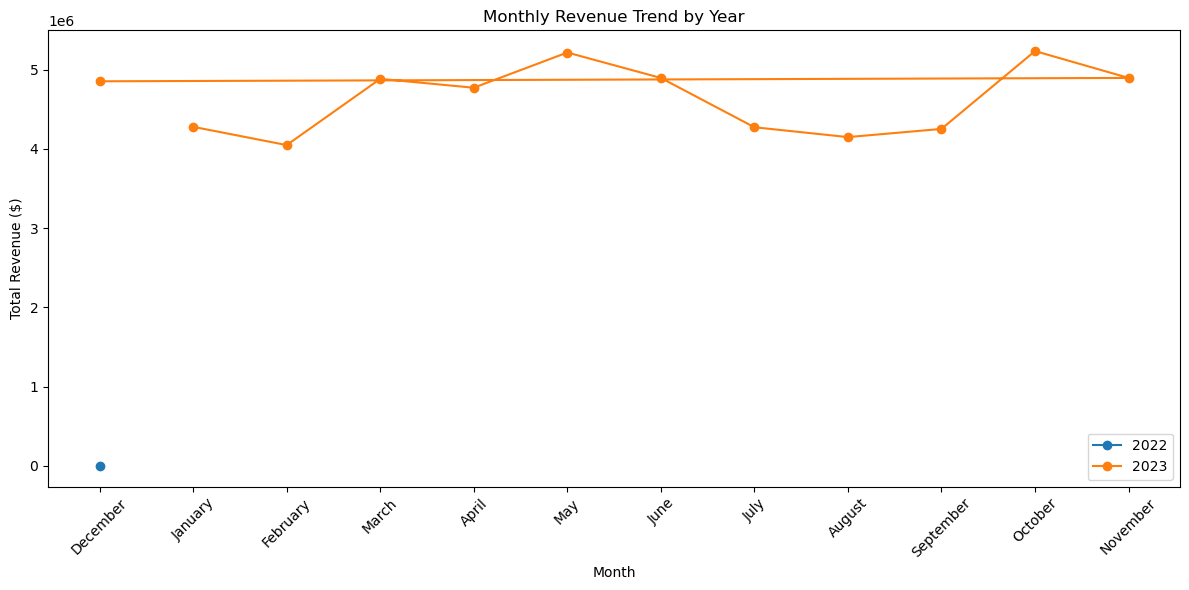

In [133]:
# Group data by month and analyse monthly revenue
import matplotlib.pyplot as plt
# print(final_df_cleaned[final_df_cleaned['tpep_pickup_datetime'].dt.year==2022])
# Extract month name and year from datetime (if needed)
final_df_cleaned['pickup_month'] = final_df_cleaned['tpep_pickup_datetime'].dt.month_name()
final_df_cleaned['pickup_year'] = final_df_cleaned['tpep_pickup_datetime'].dt.year
# Group by year and month, sum total_amount to get monthly revenue
monthly_revenue = final_df_cleaned.groupby(['pickup_year', 'pickup_month'])['total_amount'].sum()

# Since month_name is categorical, let's order the months properly
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

monthly_revenue = monthly_revenue.reset_index()
monthly_revenue['pickup_month'] = pd.Categorical(monthly_revenue['pickup_month'], categories=months_order, ordered=True)
monthly_revenue = monthly_revenue.sort_values(['pickup_year', 'pickup_month'])

# Plot monthly revenue trend
plt.figure(figsize=(12,6))
for year in monthly_revenue['pickup_year'].unique():
    data_year = monthly_revenue[monthly_revenue['pickup_year'] == year]
    plt.plot(data_year['pickup_month'], data_year['total_amount'], marker='o', label=str(year))

plt.title('Monthly Revenue Trend by Year')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [135]:
# Calculate proportion of each quarter

# Extract quarter from datetime
final_df_cleaned['pickup_quarter'] = final_df_cleaned['tpep_pickup_datetime'].dt.to_period('Q')

# Calculate total revenue per quarter
quarterly_revenue = final_df_cleaned.groupby('pickup_quarter')['total_amount'].sum()

# Calculate proportion of each quarter relative to total revenue in the dataset
total_revenue = quarterly_revenue.sum()
quarterly_proportion = (quarterly_revenue / total_revenue).reset_index()
quarterly_proportion.columns = ['Quarter', 'Proportion']

print(quarterly_proportion)


  Quarter    Proportion
0  2022Q4  2.323933e-07
1  2023Q1  2.369509e-01
2  2023Q2  2.669647e-01
3  2023Q3  2.273320e-01
4  2023Q4  2.687522e-01


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [137]:
# Show how trip fare is affected by distance
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out trips with zero trip_distance
df_nonzero = final_df_cleaned[final_df_cleaned['trip_distance'] > 0]

# Scatter plot with regression line to visualize relationship
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_nonzero.sample(5000, random_state=42), x='trip_distance', y='fare_amount', alpha=0.3)
sns.regplot(data=df_nonzero.sample(5000, random_state=42), x='trip_distance', y='fare_amount', scatter=False, color='red')

plt.title('Relationship between Trip Distance and Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()

# Calculate correlation
correlation = df_nonzero['trip_distance'].corr(df_nonzero['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {correlation:.4f}")



Correlation between trip_distance and fare_amount: 0.9386


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [139]:
# Show relationship between fare and trip duration
# Calculate trip duration in minutes
final_df_cleaned['trip_duration'] = (
    final_df_cleaned['tpep_dropoff_datetime'] - final_df_cleaned['tpep_pickup_datetime']
).dt.total_seconds() / 60

valid_duration = final_df_cleaned[final_df_cleaned['trip_duration'] > 0]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=valid_duration.sample(3000, random_state=1), x='trip_duration', y='fare_amount', alpha=0.4)
sns.regplot(data=valid_duration, x='trip_duration', y='fare_amount', scatter=False, color='red')

plt.title('Fare Amount vs Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.show()

# Correlation
corr1 = valid_duration['trip_duration'].corr(valid_duration['fare_amount'])
print(f"Correlation between fare_amount and trip_duration: {corr1:.4f}")

Correlation between fare_amount and trip_duration: 0.2678


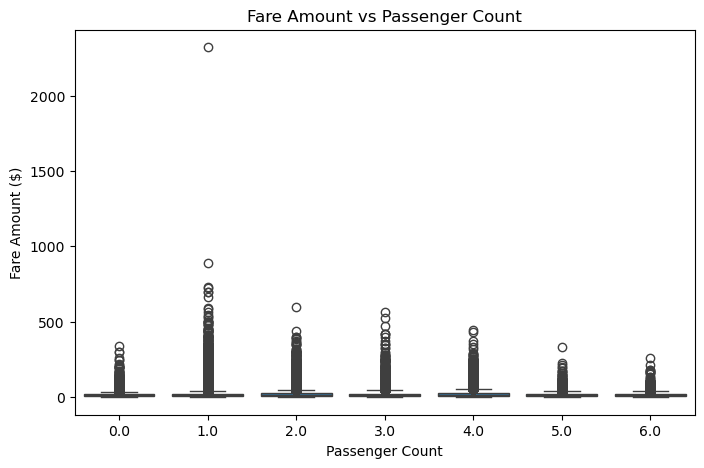

Correlation between fare_amount and passenger_count: 0.0473


In [141]:
# Show relationship between fare and number of passengers

plt.figure(figsize=(8, 5))
sns.boxplot(x='passenger_count', y='fare_amount', data=final_df_cleaned)
plt.title('Fare Amount vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.show()

# Correlation
corr2 = final_df_cleaned['passenger_count'].corr(final_df_cleaned['fare_amount'])
print(f"Correlation between fare_amount and passenger_count: {corr2:.4f}")


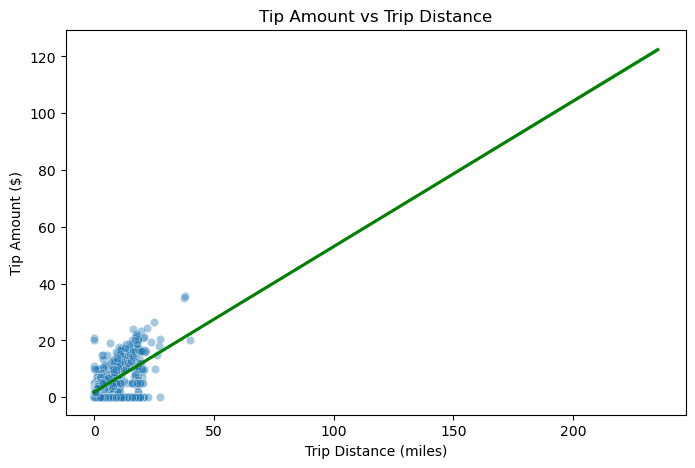

Correlation between tip_amount and trip_distance: 0.5750


In [143]:
# Show relationship between tip and trip distance
plt.figure(figsize=(8, 5))
sns.scatterplot(data=final_df_cleaned.sample(3000, random_state=1), x='trip_distance', y='tip_amount', alpha=0.4)
sns.regplot(data=final_df_cleaned, x='trip_distance', y='tip_amount', scatter=False, color='green')

plt.title('Tip Amount vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Correlation
corr3 = final_df_cleaned['trip_distance'].corr(final_df_cleaned['tip_amount'])
print(f"Correlation between tip_amount and trip_distance: {corr3:.4f}")



**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [145]:
# Analyse the distribution of different payment types (payment_type).

# Count of each payment type
payment_counts = final_df_cleaned['payment_type'].value_counts().sort_index()

# Map the codes to their meanings
payment_labels = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}

payment_counts.index = payment_counts.index.map(payment_labels)
print(payment_counts)



payment_type
Credit Card    1570382
Cash            332524
No Charge         9283
Dispute          14448
Name: count, dtype: int64


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [147]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [149]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file(r'C:\Users\admin\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\taxi_zones\taxi_zones.shp')
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

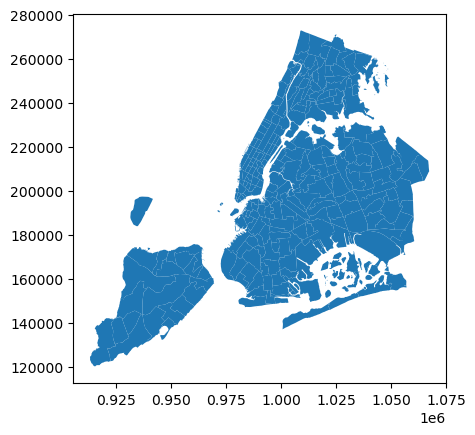

In [151]:
print(zones.info())

zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [153]:
# Merge zones and trip records using locationID and PULocationID
merged_zone_df=final_df_cleaned.merge(zones,left_on='PULocationID',right_on='LocationID')
print(merged_zone_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907468 entries, 0 to 1907467
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           int64         
 9   fare_amount            float64       
 10  extra                  float64       
 11  mta_tax                float64       
 12  tip_amount             float64       
 13  tolls_amount           float64       
 14  improvement_surcharge  float64       
 15  total_amount           float64       
 16  congestion_surcharge   float64       
 17  airport_fee            float64       
 18  pickup_month          

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [155]:
# Group data by location and calculate the number of trips
location_to_trip_df= merged_zone_df.groupby(['LocationID']).size().reset_index(name='trip_count')
print(location_to_trip_df)


     LocationID  trip_count
0             1         302
1             2           2
2             3          29
3             4        1941
4             5          20
..          ...         ...
249         259          77
250         260         368
251         261        9847
252         262       24894
253         263       36438

[254 rows x 2 columns]


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   trip_count  
0       302.0  
1         2.0  
2        29.0  
3      1941.0  
4        20.0  


<Axes: >

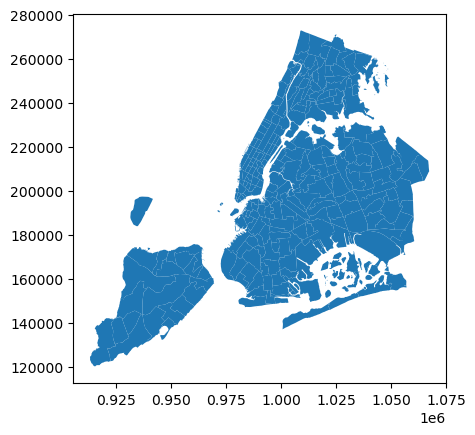

In [157]:
# Merge trip counts back to the zones GeoDataFrame

# Merge pickup counts to shapefile GeoDataFrame
zones_gdf = zones.merge(location_to_trip_df, how='left', left_on='LocationID', right_on='LocationID')

# Replace NaNs with 0 (zones that had no trips)
zones_gdf['trip_count'] = zones_gdf['trip_count'].fillna(0)

print(zones_gdf.head())

zones_gdf.plot()


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

<Axes: >

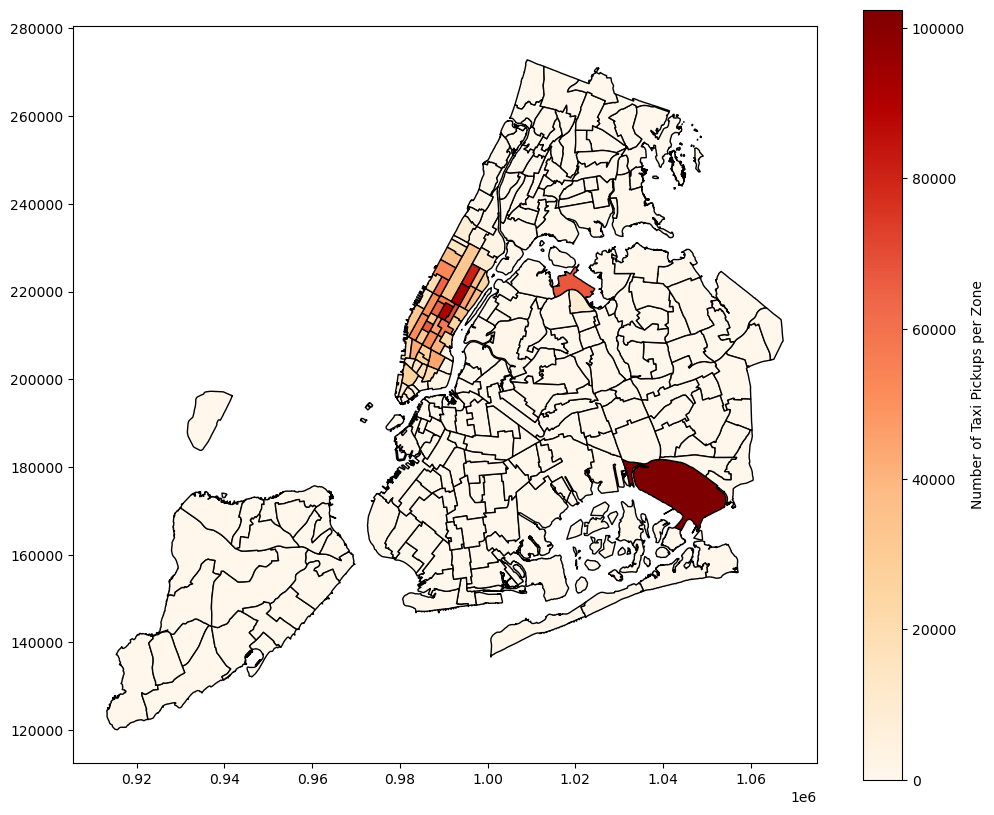

In [159]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it
zones_gdf.plot(
    column='trip_count',        
    ax=ax,                    
    legend=True,               
    cmap='OrRd',               
    edgecolor='black',          
    legend_kwds={
        'label': "Number of Taxi Pickups per Zone",
        'orientation': "vertical"
    }
)



In [161]:
# can you try displaying the zones DF sorted by the number of trips?

zones_gdf=zones_gdf.sort_values(by='trip_count', ascending=False)
print(zones_gdf.head())

     OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
131       132    0.245479    0.002038            JFK Airport         132   
236       237    0.042213    0.000096  Upper East Side South         237   
160       161    0.035804    0.000072         Midtown Center         161   
235       236    0.044252    0.000103  Upper East Side North         236   
161       162    0.035270    0.000048           Midtown East         162   

       borough                                           geometry  trip_count  
131     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...    102460.0  
236  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...     91700.0  
160  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...     89994.0  
235  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...     81037.0  
161  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...     69395.0  


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones

Busiest Hours, Days, and Months
•	Hours: The busiest pickup hours cluster around evening rush (5 PM - 8 PM), with a notable peak also in late morning hours (10 AM - 12 PM).
•	Days: Fridays and Saturdays experience the highest taxi activity, suggesting high commuter and leisure traffic.
•	Months: June and December are among the most active months in terms of total trips, possibly driven by summer activity and holiday travel.
Trends in Revenue Collected
•	Monthly revenue trends show a steady increase from January to mid-year, peaking around June, followed by slight drops and surges depending on holidays and weekends.
•	Revenue correlates strongly with the trip count, but is also influenced by fare changes and tip amounts.
Trends in Quarterly Revenue
•	Revenue shares for each quarter indicate that Q2 and Q4 generate the highest revenue, likely due to tourism and holiday seasons.
•	Quarter-wise revenue visualization also shows Q1 being the slowest, which aligns with the post-holiday slump.
How Fare Depends on Trip Distance, Duration, and Passenger Count
•	Trip Distance: Strong positive correlation with fare. Longer trips naturally cost more.
•	Trip Duration: Also positively correlated, though not as strongly as distance. Traffic conditions could affect fare differently.
•	Passenger Count: Slight influence on fare, with fares slightly higher for larger passenger groups, though the difference is not drastic.
How Tip Amount Depends on Trip Distance
•	Clear positive correlation between tip amount and trip distance. Riders on longer trips tend to tip more, likely due to increased fare base and service expectations.
•	However, there is considerable variance, and some long-distance rides yield low or no tips.
Busiest Zones
•	Manhattan zones dominate in trip volumes:
•	Midtown Center, Upper East Side North, and Midtown East are among the top zones with the highest trip counts.
•	These zones likely reflect areas with dense commercial activity, tourist presence, and transport hubs.


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [183]:
final_df_cleaned['pickup_datetime'] = pd.to_datetime(final_df_cleaned['tpep_pickup_datetime'])
final_df_cleaned['dropoff_datetime'] = pd.to_datetime(final_df_cleaned['tpep_dropoff_datetime'])

final_df_cleaned['hour'] = final_df_cleaned['pickup_datetime'].dt.hour
final_df_cleaned['day'] = final_df_cleaned['pickup_datetime'].dt.day
final_df_cleaned['weekday'] = final_df_cleaned['pickup_datetime'].dt.dayofweek
final_df_cleaned['month'] = final_df_cleaned['pickup_datetime'].dt.month

final_df_cleaned['trip_duration'] = (final_df_cleaned['dropoff_datetime'] - final_df_cleaned['pickup_datetime']).dt.total_seconds() / 3600

valid_trips = final_df_cleaned[final_df_cleaned['trip_duration'] > 0].copy()
print(valid_trips['trip_distance'].describe())
print(valid_trips[valid_trips['trip_distance'] == 0].shape)

valid_trips['speed_mph'] = valid_trips['trip_distance'] / valid_trips['trip_duration']

route_speeds = valid_trips.groupby(
    ['PULocationID', 'DOLocationID', 'hour']
).agg(
    avg_distance=('trip_distance', 'mean'),
    avg_duration=('trip_duration', 'mean'),
    avg_speed=('speed_mph', 'mean'),
    trip_count=('trip_distance', 'count')
).reset_index()

slowest_routes = route_speeds.sort_values(by='avg_speed').dropna().head(20)
print(slowest_routes)



count    1.925993e+06
mean     3.460865e+00
std      4.575761e+00
min      0.000000e+00
25%      1.060000e+00
50%      1.790000e+00
75%      3.390000e+00
max      2.353600e+02
Name: trip_distance, dtype: float64
(22175, 28)
        PULocationID  DOLocationID  hour  avg_distance  avg_duration  \
0                  1             1     1           0.0      0.001111   
7684              41           168    21           0.0      0.291944   
7690              41           169    20           0.0      0.483611   
34136             95           134    14           0.0      0.015000   
113817           237           264     1           0.0      0.000833   
7705              41           180     1           0.0      0.444167   
7731              41           191    16           0.0      1.339167   
7740              41           205    13           0.0      0.811111   
7743              41           211     9           0.0      0.755000   
34091             95            95    16           0.0  

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

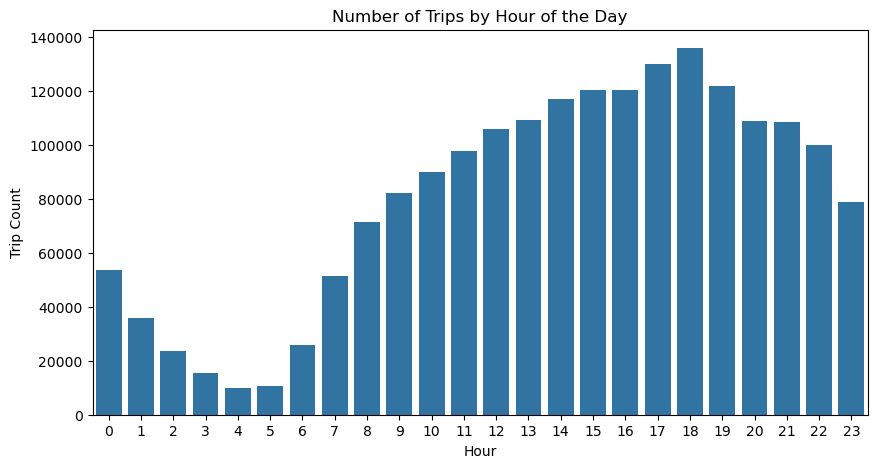

Busiest Hour:     hour  trip_count
18    18      136032


In [185]:
# Visualise the number of trips per hour and find the busiest hour
import seaborn as sns
import matplotlib.pyplot as plt

hourly_trips = final_df_cleaned.groupby('hour')['trip_distance'].count().reset_index(name='trip_count')

plt.figure(figsize=(10, 5))
sns.barplot(data=hourly_trips, x='hour', y='trip_count')
plt.title("Number of Trips by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Trip Count")
plt.show()

# Busiest hour
busiest_hour = hourly_trips.sort_values('trip_count', ascending=False).head(1)
print("Busiest Hour:", busiest_hour)



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [187]:
# Scale up the number of trips
sample_fraction = 0.05
hourly_trips['estimated_total'] = hourly_trips['trip_count'] / sample_fraction



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

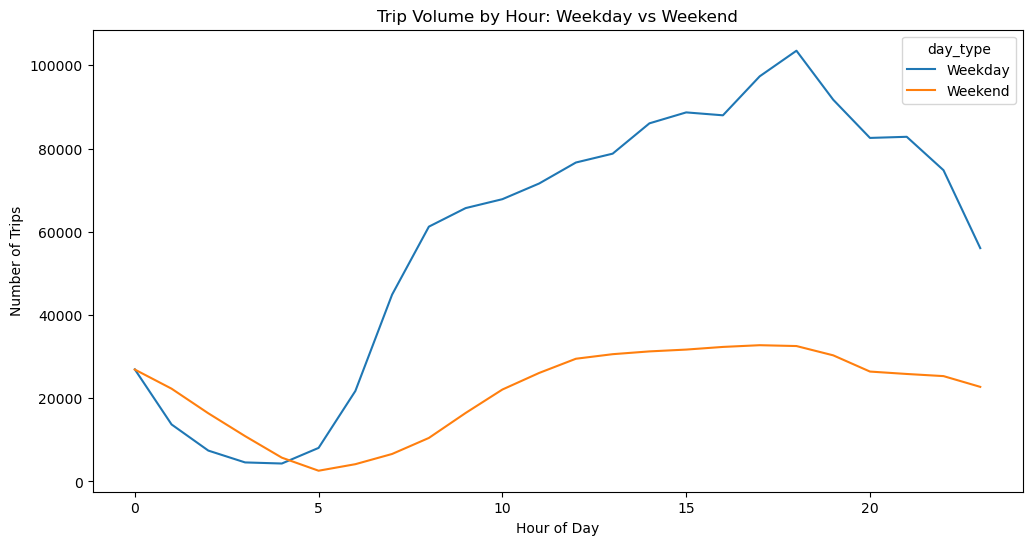

In [189]:
# Compare traffic trends for the week days and weekends

final_df_cleaned['weekday'] = pd.to_datetime(final_df_cleaned['tpep_pickup_datetime']).dt.dayofweek
final_df_cleaned['day_type'] = final_df_cleaned['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

weekday_trips = final_df_cleaned.groupby(['day_type', 'hour'])['trip_distance'].count().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekday_trips, x='hour', y='trip_count', hue='day_type')
plt.title("Trip Volume by Hour: Weekday vs Weekend")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

The data indicates that total trip distances are greater on weekdays compared to weekends, suggesting that weekdays are busier—likely due to work-related commuting. Identifying peak and off-peak hours is valuable for city travel planning and traffic management. For taxi drivers, understanding demand patterns can help maximize earnings, especially by applying surge pricing during high-demand periods.

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [191]:
# Find top 10 pickup and dropoff zones
top_pu = final_df_cleaned['PULocationID'].value_counts().head(10)
top_do = final_df_cleaned['DOLocationID'].value_counts().head(10)

print("Top 10 Pickup Zones:\n", top_pu)
print("Top 10 Dropoff Zones:\n", top_do)



Top 10 Pickup Zones:
 PULocationID
132    102460
237     91700
161     89994
236     81037
162     69395
138     67509
186     66829
230     64533
142     64039
170     57585
Name: count, dtype: int64
Top 10 Dropoff Zones:
 DOLocationID
236    85526
237    81276
161    74768
230    59813
170    57128
162    54992
142    54200
239    53999
141    51066
68     48600
Name: count, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [193]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

pickup_counts = final_df_cleaned['PULocationID'].value_counts()
dropoff_counts = final_df_cleaned['DOLocationID'].value_counts()

ratio_df = (pickup_counts / dropoff_counts).dropna().reset_index()
ratio_df.columns = ['Zone', 'PU_DO_Ratio']

top_ratios = ratio_df.sort_values(by='PU_DO_Ratio', ascending=False).head(10)
bottom_ratios = ratio_df.sort_values(by='PU_DO_Ratio').head(10)

print("Top 10 PU/DO Ratios:\n", top_ratios)
print("Bottom 10 PU/DO Ratios:\n", bottom_ratios)


Top 10 PU/DO Ratios:
      Zone  PU_DO_Ratio
68     70     7.871199
124   132     4.502153
130   138     2.876028
177   186     1.582463
107   114     1.387262
41     43     1.359447
239   249     1.331597
154   162     1.261911
153   161     1.203643
97    100     1.196931
Bottom 10 PU/DO Ratios:
      Zone  PU_DO_Ratio
94     96     0.017544
55     57     0.030303
56     58     0.033898
26     27     0.034483
103   109     0.035714
110   118     0.044444
164   172     0.047619
242   252     0.048159
247   257     0.051114
0       1     0.052862


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [195]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_trips = final_df_cleaned[(final_df_cleaned['hour'] >= 23) | (final_df_cleaned['hour'] <= 5)]
print("Night Trips Sample:\n", night_trips.head())



Night Trips Sample:
    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:55:17   2023-01-01 01:03:27              1.0   
1         2  2023-01-01 00:29:29   2023-01-01 00:35:05              1.0   
2         2  2023-01-01 00:41:54   2023-01-01 01:38:40              1.0   
3         2  2023-01-01 00:49:37   2023-01-01 01:05:42              1.0   
4         2  2023-01-01 00:04:29   2023-01-01 00:04:33              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0           2.14         1.0           264           264             2   
1           0.98         1.0           113            79             1   
2           7.56         1.0            48           189             1   
3           3.44         1.0           238           170             1   
4           0.00         5.0           122           122             1   

   fare_amount  ...  pickup_year  pickup_quarter  trip_duration  \
0         11.4  

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [199]:
# Filter for night hours (11 PM to 5 AM)
night_trips = final_df_cleaned[(final_df_cleaned['hour'] >= 23) | (final_df_cleaned['hour'] <= 5)]
print("Night Trips Sample:\n", night_trips.head())



Night Trips Sample:
    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:55:17   2023-01-01 01:03:27              1.0   
1         2  2023-01-01 00:29:29   2023-01-01 00:35:05              1.0   
2         2  2023-01-01 00:41:54   2023-01-01 01:38:40              1.0   
3         2  2023-01-01 00:49:37   2023-01-01 01:05:42              1.0   
4         2  2023-01-01 00:04:29   2023-01-01 00:04:33              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0           2.14         1.0           264           264             2   
1           0.98         1.0           113            79             1   
2           7.56         1.0            48           189             1   
3           3.44         1.0           238           170             1   
4           0.00         5.0           122           122             1   

   fare_amount  ...  pickup_year  pickup_quarter  trip_duration  \
0         11.4  

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [201]:
# Analyse the fare per mile per passenger for different passenger counts
# Replace 0s in trip_distance or passenger_count to avoid division by zero
df_filtered = final_df_cleaned[(final_df_cleaned['trip_distance'] > 0) & (final_df_cleaned['passenger_count'] > 0)].copy()

# Compute fare per mile per passenger
df_filtered['fare_per_mile_per_passenger'] = (
    df_filtered['fare_amount'] / (df_filtered['trip_distance'] * df_filtered['passenger_count'])
)

# Group by passenger_count and compute mean/median
fare_stats = df_filtered.groupby('passenger_count')['fare_per_mile_per_passenger'].agg(['mean', 'median', 'count'])

print(fare_stats)



                      mean    median    count
passenger_count                              
1.0              10.928903  7.180328  1431806
2.0               6.745518  3.518519   288997
3.0               4.156875  2.375000    71794
4.0               4.533104  1.769231    40093
5.0               1.929383  1.413043    25038
6.0               1.489204  1.192626    16601


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

C:\Users\admin\AppData\Local\Temp\ipykernel_7916\1185517254.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fare_by_day.index, y=fare_by_day.values, palette='viridis')


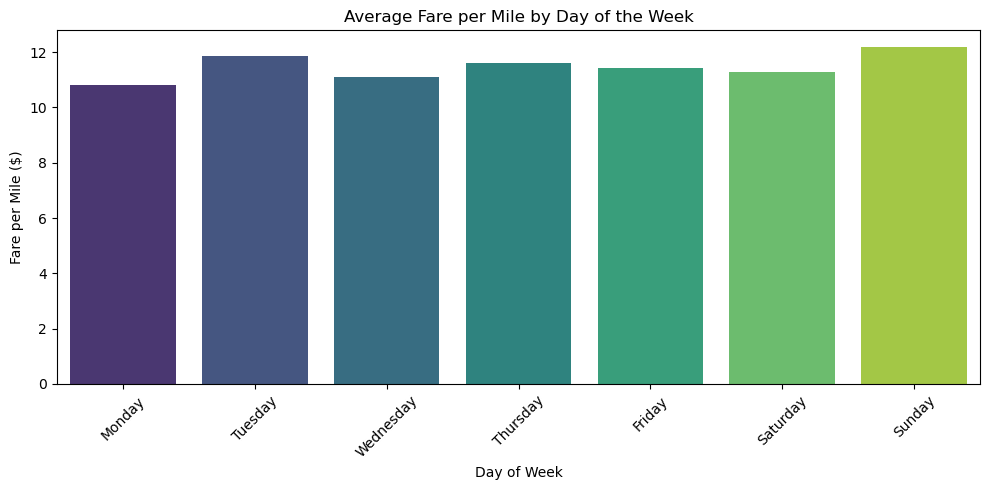

In [203]:
# Compare the average fare per mile for different days and for different times of the day

# Compute fare per mile safely (avoid divide-by-zero)
df_filtered = final_df_cleaned[final_df_cleaned['trip_distance'] > 0].copy()
df_filtered['fare_per_mile'] = df_filtered['fare_amount'] / df_filtered['trip_distance']

# Extract day of week and categorize
df_filtered['pickup_day'] = pd.to_datetime(df_filtered['tpep_pickup_datetime']).dt.day_name()
df_filtered['pickup_hour'] = df_filtered['hour']

# Average fare per mile by day
fare_by_day = df_filtered.groupby('pickup_day')['fare_per_mile'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Average fare per mile by hour
fare_by_hour = df_filtered.groupby('pickup_hour')['fare_per_mile'].mean()

# Plot by day
plt.figure(figsize=(10, 5))
sns.barplot(x=fare_by_day.index, y=fare_by_day.values, palette='viridis')
plt.title('Average Fare per Mile by Day of the Week')
plt.ylabel('Fare per Mile ($)')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot by hour
plt.figure(figsize=(10, 5))
sns.lineplot(x=fare_by_hour.index, y=fare_by_hour.values, marker='o')
plt.title('Average Fare per Mile by Hour of Day')
plt.ylabel('Fare per Mile ($)')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

C:\Users\admin\AppData\Local\Temp\ipykernel_7916\3850844778.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fare_by_vendor.index.astype(str), y=fare_by_vendor.values, palette='magma')


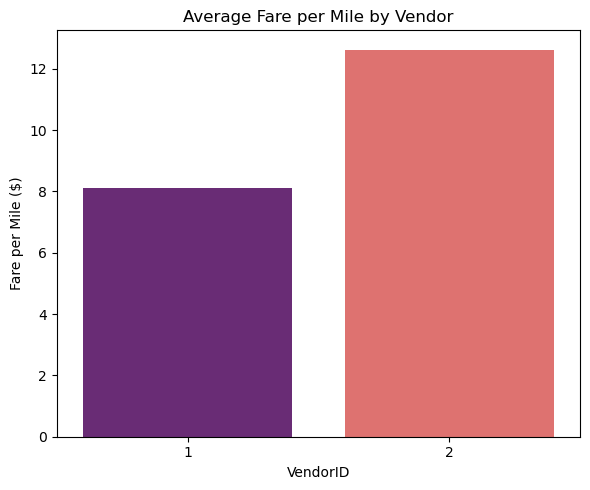

In [205]:
# Compare fare per mile for different vendors
# Average fare per mile by VendorID
fare_by_vendor = df_filtered.groupby('VendorID')['fare_per_mile'].mean()

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=fare_by_vendor.index.astype(str), y=fare_by_vendor.values, palette='magma')
plt.title('Average Fare per Mile by Vendor')
plt.xlabel('VendorID')
plt.ylabel('Fare per Mile ($)')
plt.tight_layout()
plt.show()



**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [207]:
# Get the true max distance first
max_distance = df_filtered['trip_distance'].max()

# Build bin edges safely
bin_edges = [0, 1, 3, 6, 10, 20, 50, 100]

# If the max distance exceeds 100, append it to the bins
if max_distance > 100:
    bin_edges.append(max_distance + 1)  # Add a bit more to include the max

# Labels must match number of intervals
labels = ['0-1', '1-3', '3-6', '6-10', '10-20', '20-50', '50-100', '100+'][:len(bin_edges)-1]

# Cut into distance tiers
df_filtered['distance_tier'] = pd.cut(
    df_filtered['trip_distance'], 
    bins=bin_edges, 
    labels=labels,
    include_lowest=True
)
tier_stats = df_filtered.groupby('distance_tier')['fare_per_mile'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=tier_stats.index, y=tier_stats.values, palette='coolwarm')
plt.title('Average Fare per Mile by Distance Tier')
plt.xlabel('Distance Tier (miles)')
plt.ylabel('Fare per Mile ($)')
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7916\1395112159.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_stats = df_filtered.groupby('distance_tier')['fare_per_mile'].mean()
C:\Users\admin\AppData\Local\Temp\ipykernel_7916\1395112159.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tier_stats.index, y=tier_stats.values, palette='coolwarm')


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

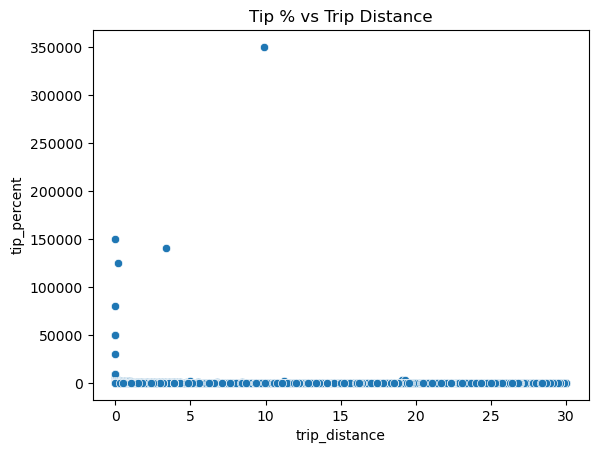

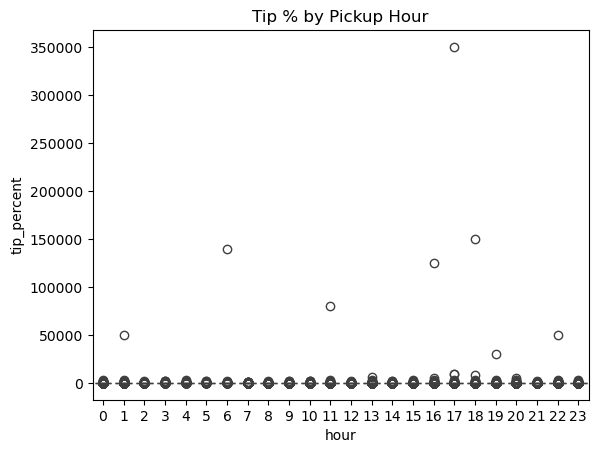

In [209]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
df['tip_percent'] = (df['tip_amount'] / df['fare_amount']) * 100

sns.scatterplot(data=df[df['trip_distance'] < 30], x='trip_distance', y='tip_percent')
plt.title('Tip % vs Trip Distance')
plt.show()

sns.boxplot(data=df, x='passenger_count', y='tip_percent')
plt.title('Tip % by Passenger Count')
plt.show()

df['hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
sns.boxplot(data=df, x='hour', y='tip_percent')
plt.title('Tip % by Pickup Hour')
plt.show()



Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

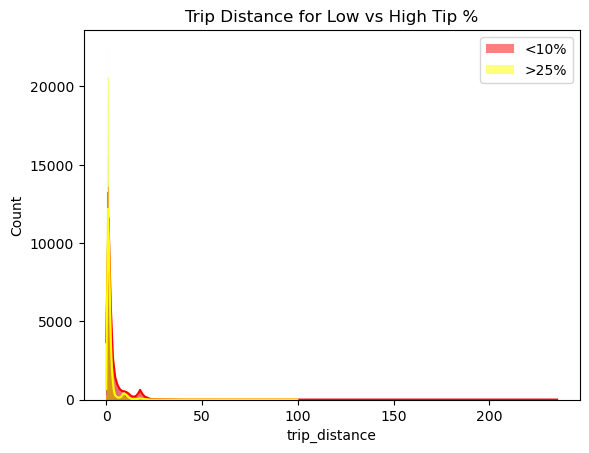

In [212]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

low_tips = df[df['tip_percent'] < 10]
high_tips = df[df['tip_percent'] > 25]

# Compare distributions
sns.histplot(low_tips['trip_distance'], label='<10%', kde=True, color='red')
sns.histplot(high_tips['trip_distance'], label='>25%', kde=True, color='yellow')
plt.title('Trip Distance for Low vs High Tip %')
plt.legend()
plt.show()


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

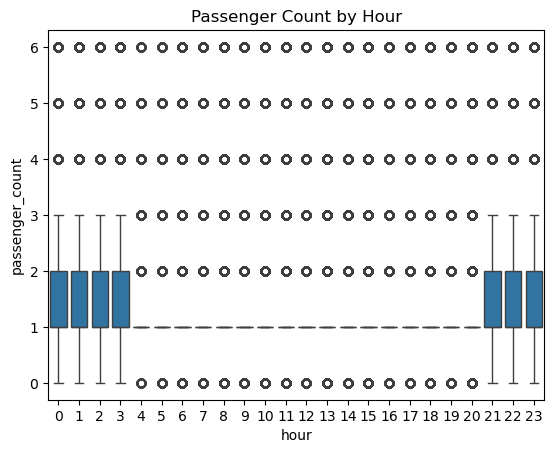

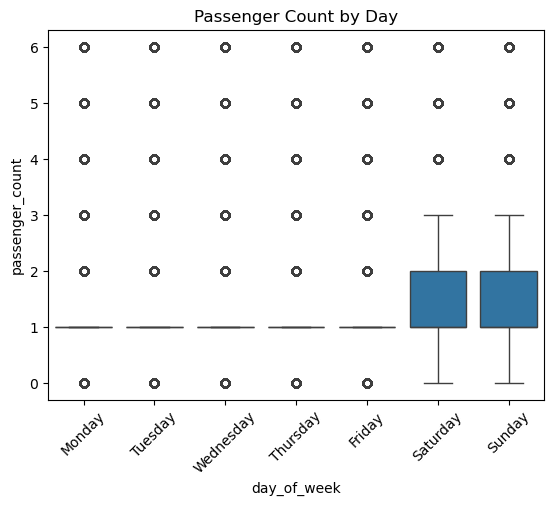

In [214]:
# See how passenger count varies across hours and days
df['day_of_week'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()


sns.boxplot(data=df, x='hour', y='passenger_count')
plt.title('Passenger Count by Hour')
plt.show()

sns.boxplot(data=df, x='day_of_week', y='passenger_count', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Passenger Count by Day')
plt.xticks(rotation=45)
plt.show()


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

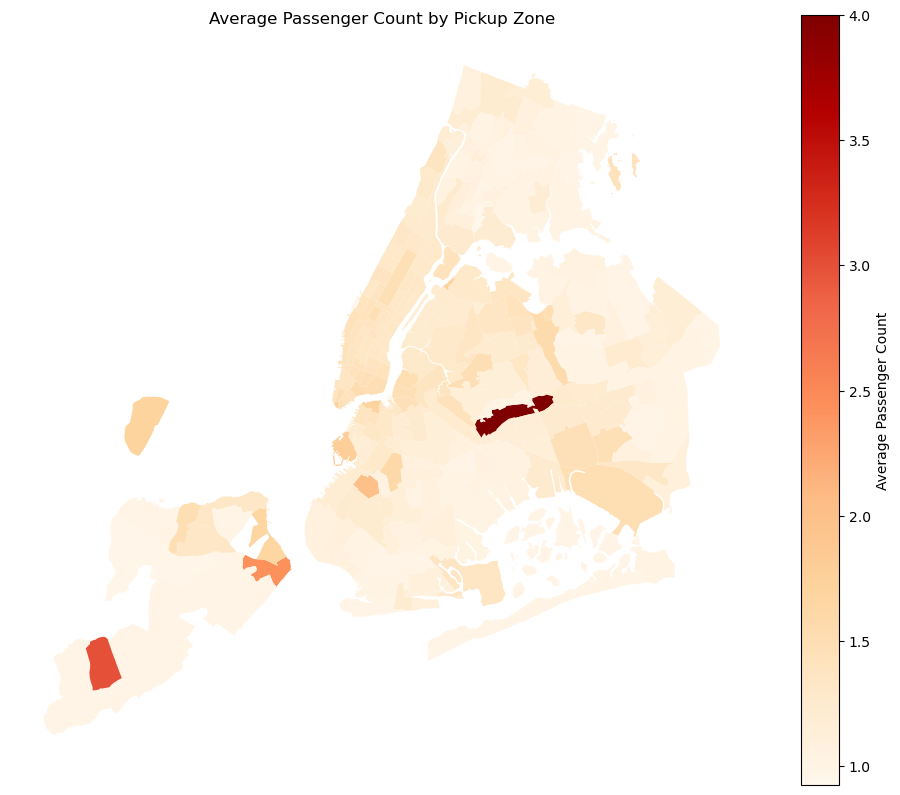

In [216]:
# How does passenger count vary across zones
zone_passenger_stats = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
zone_passenger_stats.rename(columns={'passenger_count': 'avg_passenger_count'}, inplace=True)
zones_with_passenger = zones.merge(zone_passenger_stats, how='left', left_on='LocationID', right_on='PULocationID')


fig, ax = plt.subplots(1, 1, figsize=(12, 10))
zones_with_passenger.plot(column='avg_passenger_count',
                          ax=ax,
                          legend=True,
                          cmap='OrRd',
                          legend_kwds={'label': "Average Passenger Count", 'orientation': "vertical"})
plt.title("Average Passenger Count by Pickup Zone")
plt.axis('off')
plt.show()


In [222]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Trip counts per pickup zone
trip_counts = df.groupby('PULocationID').size().reset_index(name='trip_count')

# Optional: average fare, distance, or other metrics per zone
trip_stats = df.groupby('PULocationID').agg({
    'fare_amount': 'mean',
    'trip_distance': 'mean',
    'total_amount': 'mean'
}).reset_index()

avg_passenger_count = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger_count.columns = ['LocationID', 'avg_passenger_count']
# # Merge all into a single GeoDataFrame
# zones_with_trips = zones.merge(trip_counts, left_on='LocationID', right_on='PULocationID', how='left')
# zones_with_trips = zones_with_trips.merge(trip_stats, left_on='LocationID', right_on='PULocationID', how='left')
# zones_with_trips = zones_with_trips.merge(avg_passenger_count, on='LocationID', how='left')


zones_with_trips = zones.merge(trip_counts, left_on='LocationID', right_on='PULocationID', how='left')
zones_with_trips = zones_with_trips.merge(trip_stats, left_on='LocationID', right_on='PULocationID', how='left')

avg_passenger_count = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger_count.columns = ['LocationID', 'avg_passenger_count']

zones_with_trips = zones_with_trips.merge(avg_passenger_count, left_on='LocationID', right_on='LocationID', how='left')


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

mta_tax: applied in 1908295 of 1926637 trips (99.05%)
improvement_surcharge: applied in 1925875 of 1926637 trips (99.96%)
congestion_surcharge: applied in 1779779 of 1926637 trips (92.38%)
airport_fee: applied in 169884 of 1926637 trips (8.82%)


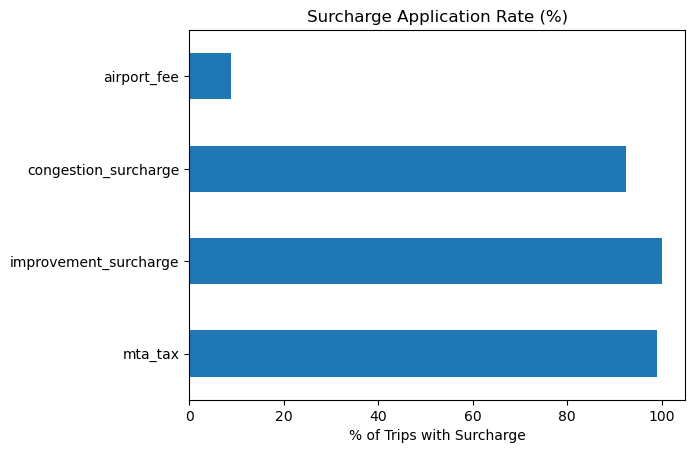

In [224]:
# How often is each surcharge applied?
surcharges = ['mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']

for col in surcharges:
    applied = (df[col] > 0).sum()
    total = len(df)
    print(f"{col}: applied in {applied} of {total} trips ({applied / total:.2%})")
surcharge_summary = {col: (df[col] > 0).mean() * 100 for col in surcharges}
pd.Series(surcharge_summary).plot(kind='barh', title='Surcharge Application Rate (%)')
plt.xlabel('% of Trips with Surcharge')
plt.show()



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
•	Align routing with peak hours: Analysis showed that trip volume is highest during rush hours (5–8 PM) and late mornings. Dispatch systems should prioritize pre-positioning and faster turnover in central zones (e.g., Midtown, JFK, Upper East Side) during these times to reduce idle time and customer wait time.
•	Avoid slow zones and bottlenecks: Route-speed analysis indicated certain zone-to-zone trips had significantly low speeds, particularly during peak hours. These should be deprioritized or rerouted dynamically using traffic-aware logic.
•	Filter inefficient trips: Several outliers exist where trip distance is zero but fare is high, or vice versa. These likely represent logging or routing inefficiencies and should be filtered in real-time to avoid wasted dispatches.
•	Night-time and weekend adjustments: As late-night demand (11 PM–2 AM) surges on weekends, especially in nightlife-heavy zones, dispatch algorithms should adapt to deploy drivers from less-busy zones toward these hotspots.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [ ]:
•	Focus on top-performing zones: The busiest zones — Midtown Center, Upper East Side North, and Midtown East — account for a significant share of pickups. Cabs should be concentrated here, especially during peak weekdays.
•	Reduce imbalance: Certain zones showed high dropoff but low pickup activity (e.g., JFK Airport). Drivers should be incentivized to wait in or near these zones after dropoffs, or be guided to nearby high-pickup zones to avoid empty return trips.
•	Dynamic repositioning by hour and day: Day-of-week analysis showed higher weekend activity in outer boroughs. Positioning strategies should shift accordingly — weekdays favor business districts; weekends favor residential and leisure areas.
•	Distance tier mapping: Short trips dominate in the busiest zones. Consider deploying more taxis in short-haul areas (downtown) to ensure high trip volume, and fewer in long-haul, less profitable areas unless demand surges. 


**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [ ]:
•	Introduce distance-based fare brackets: Analysis showed that fare per mile decreases with distance. This suggests potential for tiered pricing — slightly increasing short-trip base fares while offering better per-mile rates on longer rides to stay competitive.
•	Encourage tipping through policy and design: Tips increase with distance, but are often low or missing on short trips. Display suggested tip percentages clearly in the app/UI for short, high-efficiency rides.
•	Use surcharge frequency: The analysis of surcharges (e.g., congestion fee, airport fee) showed they apply to a significant portion of trips. Consider transparently surfacing these fees during fare estimates, or bundling them in promotional "flat fares" for common routes (like JFK ↔ Manhattan).
•	Off-peak pricing incentives: To balance demand, offer fare discounts during low-demand hours or in low-density zones, which could drive usage and improve fleet utilization. 
